# Friends 감정분석 with BERT(Pytorch)
참고(링크) : 

# 준비
라이브러리,파라미터 세팅

In [1]:
import tensorflow as tf
import torch
from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import time
import datetime
import json
import re
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import os

In [2]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'

MAX_LEN = 64  # 입력 토큰의 최대 시퀀스 길이
BATCH_SIZE = 32
NUM_EPOCHS = 5
TEST_SIZE = 0.2
RANDOM_SEED = 42

In [3]:
nltk.download('stopwords')
stops = set(stopwords.words('english'))
stemmer = nltk.stem.SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 4 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


In [5]:
# GPU 할당 변경하기
GPU_NUM = 3 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check

Current cuda device  3


# 데이터 로드

In [6]:
def jsonToDf(file_name):
    with open(file_name, encoding = 'utf-8', mode = 'r') as file:
        json_array = json.load(file)
  
    result = pd.DataFrame.from_dict(json_array[0])

    is_first = True
    for array in json_array:
        if is_first:
            is_first = False
            continue
    
        temp_df = pd.DataFrame.from_dict(array)
        result = result.append(temp_df, ignore_index = True)

    return result

In [7]:
train_df = jsonToDf(DATA_IN_PATH+'friends_train.json')
train2_df = jsonToDf(DATA_IN_PATH+'friends_dev.json')  # 기존 friends_dev.json 데이터를 friends_train.json과 통합
dev_df = jsonToDf(DATA_IN_PATH+'friends_test.json')  # 원 테스트 데이터는 검증용으로 사용
test_df = pd.read_csv(DATA_IN_PATH+'en_data_modified.csv')  # 테스트(캐글) 데이터

# train + dev 합치기
train_tmp = train2_df.copy()
train_df = train_df.append(train_tmp, ignore_index = True)

In [8]:
print(train_df.shape)
print(dev_df.shape)
print(test_df.shape)

(11739, 4)
(2764, 4)
(1623, 5)


In [9]:
train_df.head()

,speaker,utterance,emotion,annotation
0,Chandler,also I was the point person on my companys tr...,neutral,4100000
1,The Interviewer,You mustve had your hands full.,neutral,5000000
2,Chandler,That I did. That I did.,neutral,5000000
3,The Interviewer,So lets talk a little bit about your duties.,neutral,5000000
4,Chandler,My duties? All right.,surprise,2000030


In [10]:
dev_df.head()

,speaker,utterance,emotion,annotation
0,Mark,Why do all youre coffee mugs have numbers on ...,surprise,2000030
1,Rachel,Oh. Thats so Monica can keep track. That way ...,non-neutral,2100011
2,Rachel,Y'know what?,neutral,3000020
3,Ross,It didnt.,neutral,5000000
4,Frank,"Okay, so what you used to have with Rachel, is...",joy,1300010


In [11]:
test_df.head()

,id,i_dialog,i_utterance,speaker,utterance
0,0,0.0,0.0,Phoebe,"Alright, whadyou do with him?"
1,1,0.0,1.0,Monica,Oh! You're awake!
2,2,0.0,2.0,Joey,Then you gotta come clean with Ma! This is not...
3,3,0.0,3.0,Mr. Tribbiani,"Yeah, but this is"
4,4,0.0,4.0,Joey,I don't wanna hear it! Now go to my room!


# 데이터 탐색(EDA)

(-0.5, 799.5, 599.5, -0.5)

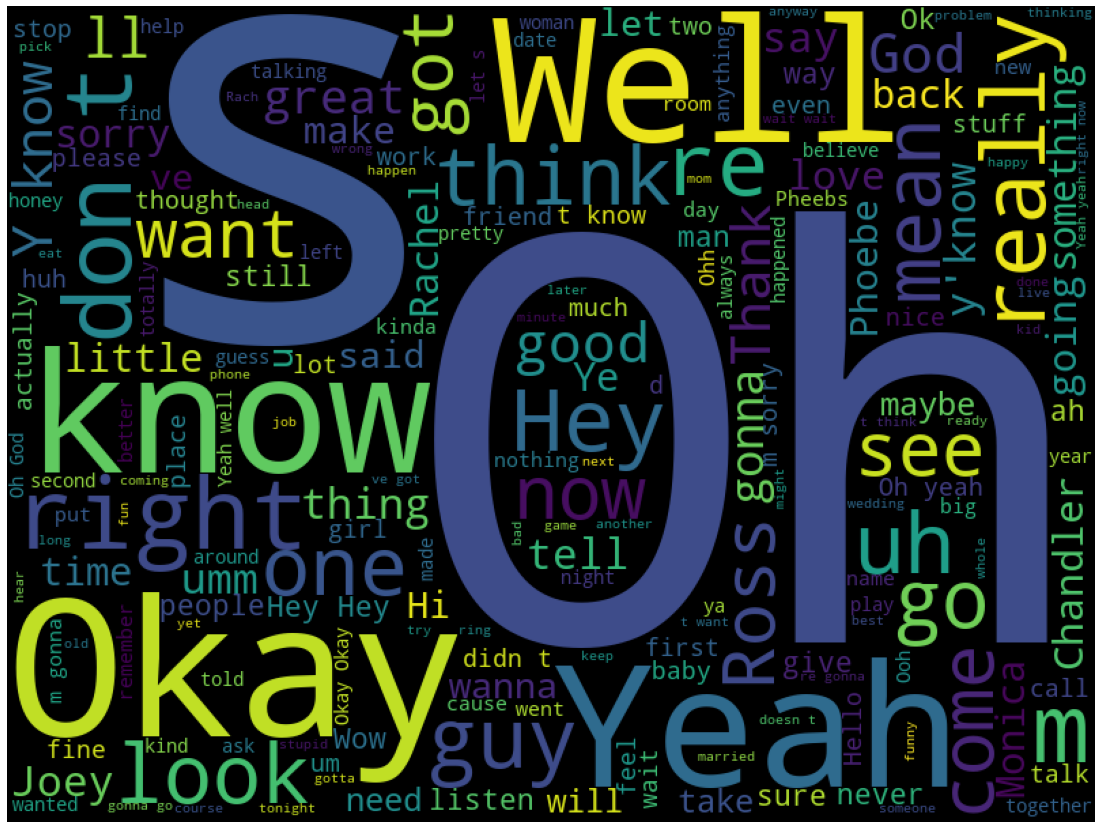

In [12]:
# 워드 클라우드 확인 (많이 사용된 단어)
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600).generate(" ".join(train_df['utterance']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

# 데이터 전처리

In [13]:
def data_cleansing(train_data, dev_data, test_data, con=0):  # 0: 전처리 없음(null값 공백 치환), 1: 숫자 제거, 2: 특수문자 제거
    global train_df
    global dev_df
    global test_df
    
    train_data = jsonToDf(DATA_IN_PATH+'friends_train.json')
    train2_df = jsonToDf(DATA_IN_PATH+'friends_dev.json')  # 기존 friends_dev.json 데이터를 friends_train.json과 통합
    dev_data = jsonToDf(DATA_IN_PATH+'friends_test.json')  # 원 테스트 데이터는 검증용으로 사용
    test_data = pd.read_csv(DATA_IN_PATH+'en_data_modified.csv')  # 테스트(캐글) 데이터
    # train + dev 합치기
    train_tmp = train2_df.copy()
    train_data = train_data.append(train_tmp, ignore_index = True)
    
    train_df = train_data.copy()
    dev_df = dev_data.copy()
    test_df = test_data.copy()
    
    train_df.drop(['speaker','annotation'], axis=1, inplace=True)
    dev_df.drop(['speaker','annotation'], axis=1, inplace=True)
    test_df.drop(['i_dialog','i_utterance','speaker'], axis=1, inplace=True)
    
    if con == 1:  # 숫자 제거 & Null 치환(공백), row 제거 없음
        # 정규 표현식을 이용해 숫자를 공백으로 변경(정규 표현식으로 \d는 숫자를 의미)
        train_df = train_df.fillna(' ')
        train_df['utterance'] = train_df['utterance'].apply( lambda x : re.sub(r"\d+", " ", x) )  # 숫자 제거
        dev_df = dev_df.fillna(' ')
        dev_df['utterance'] = dev_df['utterance'].apply( lambda x : re.sub(r"\d+", " ", x) )  # 숫자 제거
        test_df = test_df.fillna(' ')
        test_df['utterance'] = test_df['utterance'].apply( lambda x : re.sub(r"\d+", " ", x) )  # 숫자 제거
        
    elif con == 2:  # 영어 이외 제거 & Null 치환(공백), row 제거 없음
        train_df = train_df.fillna(' ')
        train_df['utterance'] = train_df['utterance'].str.replace("[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\x92]","") # 정규 표현식 수행(영어 이외 제거)
        dev_df = dev_df.fillna(' ')
        dev_df['utterance'] = dev_df['utterance'].str.replace("[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\x92]","") # 정규 표현식 수행(영어 이외 제거)
        test_df = test_df.fillna(' ')
        test_df['utterance'] = test_df['utterance'].str.replace("[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\x92]","") # 정규 표현식 수행(영어 이외 제거)
        
    else:
        train_df = train_df.fillna(' ')
        dev_df = dev_df.fillna(' ')
        test_df = test_df.fillna(' ')
    
    print('전처리 후 학습 데이터 :',train_df.shape)
    print('전처리 후 검증 데이터 :',dev_df.shape)
    print('전처리 후 테스트 데이터 :',test_df.shape)


In [14]:
# 전처리 자동화
data_cleansing(train_df, dev_df, test_df, con=2)  # 0: 전처리 없음(null값 공백 치환), 1: 숫자 제거, 2: 특수문자 제거

전처리 후 학습 데이터 : (11739, 2)
전처리 후 검증 데이터 : (2764, 2)
전처리 후 테스트 데이터 : (1623, 2)


In [15]:
train_df.head()

,utterance,emotion
0,also I was the point person on my companys tra...,neutral
1,You mustve had your hands full,neutral
2,That I did That I did,neutral
3,So lets talk a little bit about your duties,neutral
4,My duties All right,surprise


In [16]:
dev_df.head()

,utterance,emotion
0,Why do all youre coffee mugs have numbers on t...,surprise
1,Oh Thats so Monica can keep track That way if ...,non-neutral
2,Yknow what,neutral
3,It didnt,neutral
4,Okay so what you used to have with Rachel is w...,joy


In [17]:
test_df.head()

,id,utterance
0,0,Alright whadyou do with him
1,1,Oh Youre awake
2,2,Then you gotta come clean with Ma This is not ...
3,3,Yeah but this is
4,4,I dont wanna hear it Now go to my room


In [18]:
train_data = train_df
dev_data = dev_df
test_data = test_df

## 전처리 - 학습셋

In [19]:
# 대사 문장 추출
sentences = train_data['utterance']
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] also I was the point person on my companys transition from the KL5 to GR6 system [SEP]',
 '[CLS] You mustve had your hands full [SEP]',
 '[CLS] That I did That I did [SEP]',
 '[CLS] So lets talk a little bit about your duties [SEP]',
 '[CLS] My duties  All right [SEP]',
 '[CLS] Now youll be heading a whole division so youll have a lot of duties [SEP]',
 '[CLS] I see [SEP]',
 '[CLS] But therell be perhaps 30 people under you so you can dump a certain amount on them [SEP]',
 '[CLS] Good to know [SEP]',
 '[CLS] We can go into detail [SEP]']

In [20]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print(sentences[0])
print(tokenized_texts[0])

[CLS] also I was the point person on my companys transition from the KL5 to GR6 system [SEP]
['[CLS]', 'also', 'I', 'was', 'the', 'point', 'person', 'on', 'my', 'company', '##s', 'transition', 'from', 'the', 'K', '##L', '##5', 'to', 'GR', '##6', 'system', '[SEP]']


In [21]:
# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([  101, 10379,   146, 10134, 10105, 12331, 15042, 10135, 15127,
       12100, 10107, 35959, 10188, 10105,   148, 11369, 11166, 10114,
       58787, 11211, 11787,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [22]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [23]:
# def labeltoint(str):
#     return {'non-neutral': 0,
#              'neutral': 1, 
#              'joy': 2,
#              'sadness': 3,
#              'fear': 4,
#              'anger': 5,
#              'surprise': 6,
#              'disgust': 7}#[str]

# labels = []
# for i in train_data:
#     labels.append(labeltoint(i[1]))

In [24]:
# Friends 감정 딕셔너리 생성
emoset = {'non-neutral': 0,
          'neutral': 1, 
          'joy': 2,
          'sadness': 3,
          'fear': 4,
          'anger': 5,
          'surprise': 6,
          'disgust': 7}

In [25]:
# labels 데이터 처리
labels = [emoset[emo] for emo in train_data['emotion']]
labels = np.array(labels)
labels

array([1, 1, 1, ..., 3, 3, 3])

In [26]:
# 훈련셋과 검증셋으로 분리
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
                                                                                    labels,
                                                                                    random_state=RANDOM_SEED,
                                                                                    test_size=TEST_SIZE)

# 어텐션 마스크를 훈련셋과 검증셋으로 분리
train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       input_ids,
                                                       random_state=RANDOM_SEED,
                                                       test_size=TEST_SIZE)

# 데이터를 파이토치의 텐서로 변환
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [27]:
# 배치 사이즈
batch_size = BATCH_SIZE

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

## 전처리 - 검증셋

In [28]:
dev_data

,utterance,emotion
0,Why do all youre coffee mugs have numbers on t...,surprise
1,Oh Thats so Monica can keep track That way if ...,non-neutral
2,Yknow what,neutral
3,It didnt,neutral
4,Okay so what you used to have with Rachel is w...,joy
...,...,...
2759,Hey why dont you guys go get portraits done by...,neutral
2760,Thats a good idea I bet they have one of those...,joy
2761,Yeah thats great Next to that Chandler wont lo...,neutral
2762,Chandler what do you say,neutral


In [29]:
# 대사 문장 추출
sentences = dev_data['utterance']
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:10]

['[CLS] Why do all youre coffee mugs have numbers on the bottom [SEP]',
 '[CLS] Oh Thats so Monica can keep track That way if one on them is missing she can be like \x91Wheres number 27 [SEP]',
 '[CLS] Yknow what [SEP]',
 '[CLS] It didnt [SEP]',
 '[CLS] Okay so what you used to have with Rachel is what Ive got with Alice [SEP]',
 '[CLS] Now whwhat what is that like [SEP]',
 '[CLS] Its so cool man its so its just \x91cause being with her is so much better than like not being with her [SEP]',
 '[CLS] Yeah yeah [SEP]',
 '[CLS] Why cant I find that [SEP]',
 '[CLS] Dont ask me I had it and I blew it [SEP]']

In [30]:
# BERT의 토크나이저로 문장을 토큰으로 분리
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

print(sentences[0])
print(tokenized_texts[0])

[CLS] Why do all youre coffee mugs have numbers on the bottom [SEP]
['[CLS]', 'Why', 'do', 'all', 'your', '##e', 'coffee', 'mu', '##gs', 'have', 'numbers', 'on', 'the', 'bottom', '[SEP]']


In [31]:
# 토큰을 숫자 인덱스로 변환
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

input_ids[0]

array([  101, 24781, 10149, 10435, 20442, 10112, 69954, 12361, 15703,
       10529, 20953, 10135, 10105, 34787,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [32]:
# 어텐션 마스크 초기화
attention_masks = []

# 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
# 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [33]:
# labels 데이터 처리
labels = [emoset[emo] for emo in dev_data['emotion']]
labels = np.array(labels)
labels

array([6, 0, 1, ..., 1, 1, 1])

In [34]:
# 데이터를 파이토치의 텐서로 변환
dev_inputs = torch.tensor(input_ids)
dev_labels = torch.tensor(labels)
dev_masks = torch.tensor(attention_masks)

# 배치 사이즈
batch_size = BATCH_SIZE

# 파이토치의 DataLoader로 입력, 마스크, 라벨을 묶어 데이터 설정
# 학습시 배치 사이즈 만큼 데이터를 가져옴
dev_data = TensorDataset(dev_inputs, dev_masks, dev_labels)
dev_sampler = RandomSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=batch_size)

# 모델 생성

In [35]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=8)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [36]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )
epochs = NUM_EPOCHS
total_steps = len(train_dataloader) * epochs

# 학습률을 조금씩 감소시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# 모델 학습

In [37]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [38]:
# 재현을 위해 랜덤시드 고정
#seed_val = RANDOM_SEED
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

model.zero_grad()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.5f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.5f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...

  Average training loss: 1.53235
  Training epcoh took: 0:00:44

Running Validation...
  Accuracy: 0.48212
  Validation took: 0:00:03

======== Epoch 2 / 5 ========
Training...

  Average training loss: 1.33711
  Training epcoh took: 0:00:45

Running Validation...
  Accuracy: 0.51422
  Validation took: 0:00:03

======== Epoch 3 / 5 ========
Training...

  Average training loss: 1.19541
  Training epcoh took: 0:00:44

Running Validation...
  Accuracy: 0.51633
  Validation took: 0:00:03

======== Epoch 4 / 5 ========
Training...

  Average training loss: 1.06905
  Training epcoh took: 0:00:45

Running Validation...
  Accuracy: 0.51717
  Validation took: 0:00:03

======== Epoch 5 / 5 ========
Training...

  Average training loss: 0.97790
  Training epcoh took: 0:00:45

Running Validation...
  Accuracy: 0.51422
  Validation took: 0:00:03

Training complete!


# 모델 평가 - 검증 데이터셋(Original Test Dataset)

In [39]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(dev_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(dev_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.5f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


Accuracy: 0.49473
Test took: 0:00:04


# (참고) 제출 파일 생성

In [40]:
# 입력 데이터 변환
def convert_input_data(sentences):

    # BERT의 토크나이저로 문장을 토큰으로 분리
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

    # 입력 토큰의 최대 시퀀스 길이
    #MAX_LEN = 128

    # 토큰을 숫자 인덱스로 변환
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    # 문장을 MAX_LEN 길이에 맞게 자르고, 모자란 부분을 패딩 0으로 채움
    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

    # 어텐션 마스크 초기화
    attention_masks = []

    # 어텐션 마스크를 패딩이 아니면 1, 패딩이면 0으로 설정
    # 패딩 부분은 BERT 모델에서 어텐션을 수행하지 않아 속도 향상
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)

    return inputs, masks

In [41]:
# 문장 테스트
def test_sentences(sentences):

    # 평가모드로 변경
    model.eval()

    # 문장을 입력 데이터로 변환
    inputs, masks = convert_input_data(sentences)

    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
            
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()

    return logits

In [42]:
import time
start = time.time()  # 시작 시간 저장

test_preds = []
for i, sentence in enumerate(test_data['utterance']):
    logits = test_sentences([sentence])
    test_preds.append(np.argmax(logits))
    print(str(i)+"번 인덱스 데이터 처리 완료 =>", logits, np.argmax(logits))
    
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

0번 인덱스 데이터 처리 완료 => [[ 0.9641085   3.2271311   0.10393647 -1.5053698  -1.4137936  -0.9088629
   0.04233957 -0.73999673]] 1
1번 인덱스 데이터 처리 완료 => [[ 1.0202175   3.6979918  -0.01649406 -1.536699   -1.583879   -0.88778377
   0.19578707 -0.94607913]] 1
2번 인덱스 데이터 처리 완료 => [[ 1.474608    1.4340646  -0.2608913  -0.82989305 -0.32195005  0.58526504
  -1.8375441  -0.24706554]] 0
3번 인덱스 데이터 처리 완료 => [[ 1.6925575  3.267094  -1.5748161 -1.5607098 -1.4782056 -0.2071983
   1.014558  -1.088239 ]] 1
4번 인덱스 데이터 처리 완료 => [[ 1.3087583   3.1368895   0.13540524 -0.88789713 -0.9626933  -0.02342772
  -2.1446292  -0.98586786]] 1
5번 인덱스 데이터 처리 완료 => [[ 1.4559412   1.4329807  -1.2610204  -0.13203542 -0.19018011  0.9023098
  -1.9953038  -0.68643856]] 0
6번 인덱스 데이터 처리 완료 => [[ 1.6574227   2.3306885   0.7906505  -1.5550591  -1.8608603   0.03951818
  -0.9916292  -1.2838727 ]] 1
7번 인덱스 데이터 처리 완료 => [[ 1.5668406   0.43400496 -1.4223082   0.77061754  0.12186272  0.18453105
  -1.3132565  -0.50466627]] 0
8번 인덱스 데이터 처리 완료 =

70번 인덱스 데이터 처리 완료 => [[ 1.6266756  -0.8631786  -1.1524086  -0.0389395   0.28621453  1.0632694
  -1.707671    0.15007412]] 0
71번 인덱스 데이터 처리 완료 => [[ 0.94352573  3.468489    0.5449681  -1.7489603  -2.0998542  -0.81159675
   0.18630996 -0.94274426]] 1
72번 인덱스 데이터 처리 완료 => [[ 1.7261248   3.1494644   0.32630843 -1.195425   -1.5341096  -0.85443074
  -1.1384     -1.1798887 ]] 1
73번 인덱스 데이터 처리 완료 => [[ 1.2363168   3.837927    0.2374189  -1.314016   -1.7150849  -0.32977062
  -1.1555642  -1.1725006 ]] 1
74번 인덱스 데이터 처리 완료 => [[ 1.7813458   2.475217   -0.16623123 -2.1204073  -1.7627194  -0.86998576
   1.846958   -1.3802202 ]] 1
75번 인덱스 데이터 처리 완료 => [[ 0.9146799  -0.9207617  -0.26309702 -0.21195339  0.43701357  1.3878293
  -2.2739718  -0.18612969]] 5
76번 인덱스 데이터 처리 완료 => [[ 1.1891798  2.9445128  1.5123867 -1.3650509 -1.9750013 -1.318236
  -0.6919164 -1.525801 ]] 1
77번 인덱스 데이터 처리 완료 => [[ 1.4594499   1.1557873  -2.0360484  -0.31535104 -0.46121144  1.1708314
  -0.7918283  -0.58284324]] 0
78번 인덱스 데이터 

137번 인덱스 데이터 처리 완료 => [[ 1.6072223  1.853247  -1.6009417 -1.0552135 -0.4071476  1.1184733
  -1.3642265 -0.2690129]] 1
138번 인덱스 데이터 처리 완료 => [[ 1.6703036   0.12175364 -1.8112682  -1.3563759  -0.38080862  1.4955559
   0.23256966 -0.14194691]] 0
139번 인덱스 데이터 처리 완료 => [[ 1.5687729   3.4966269  -0.51286757 -1.2858213  -1.4950634  -0.69773126
  -0.19576092 -1.0440611 ]] 1
140번 인덱스 데이터 처리 완료 => [[ 1.7977321   1.606892   -0.80405164 -0.7913159  -0.99927515  0.43893752
  -0.86461663 -0.6776193 ]] 0
141번 인덱스 데이터 처리 완료 => [[ 1.1261175  4.328432  -0.5108878 -0.763461  -1.2052307 -1.279395
  -0.5560981 -0.9108623]] 1
142번 인덱스 데이터 처리 완료 => [[ 1.8578784   2.4343739  -0.18657053 -2.080873   -1.7360555  -0.83991593
   1.6882113  -1.3585081 ]] 1
143번 인덱스 데이터 처리 완료 => [[ 1.9011729   0.8709153  -0.34834376 -1.4283296  -1.2051287  -0.15337883
  -0.29879957 -0.0070597 ]] 0
144번 인덱스 데이터 처리 완료 => [[ 1.4824598   4.038454   -0.57671285 -0.56788766 -1.00955    -1.1415472
  -0.89534044 -1.2704223 ]] 1
145번 인덱스 데이

213번 인덱스 데이터 처리 완료 => [[ 1.5920843  3.225399   0.8534324 -0.8667968 -1.6518998 -1.3378541
  -1.0958251 -1.4639364]] 1
214번 인덱스 데이터 처리 완료 => [[ 1.3207191   3.6469038   0.54241157 -1.6259395  -1.5189496  -0.42618784
  -1.3929924  -1.1372913 ]] 1
215번 인덱스 데이터 처리 완료 => [[ 0.95319533  4.332004   -0.22099051 -1.6034129  -1.6193737  -1.2971964
   0.49350038 -0.9459546 ]] 1
216번 인덱스 데이터 처리 완료 => [[ 1.6719667   1.1753429  -0.9240861   0.9800071   0.04355241 -0.3024851
  -1.9738088  -0.7896038 ]] 0
217번 인덱스 데이터 처리 완료 => [[ 1.4940993   3.6055226  -1.1325982  -1.4004726  -1.6240519  -0.66141653
   0.8379468  -0.7693229 ]] 1
218번 인덱스 데이터 처리 완료 => [[ 1.6427163   3.17925    -1.6255023  -1.2678846  -1.0796342  -0.9242404
   1.5802094  -0.87007356]] 1
219번 인덱스 데이터 처리 완료 => [[ 0.8673557  -1.0626196  -1.768366    0.5014779   0.6620927   1.7372072
  -1.816757    0.16856062]] 5
220번 인덱스 데이터 처리 완료 => [[ 1.9627233  -0.5656371   1.087131   -0.2172491  -0.7413921  -0.71190095
  -1.010877   -1.0522346 ]] 0
221번

290번 인덱스 데이터 처리 완료 => [[ 1.9696912  -1.2929058  -0.20768522 -1.4529344  -0.62024826  0.14212374
   1.7868336  -0.2674841 ]] 0
291번 인덱스 데이터 처리 완료 => [[ 1.2562284  3.1841817  1.4296722 -0.7207112 -1.5192323 -1.3949496
  -1.599369  -1.5475969]] 1
292번 인덱스 데이터 처리 완료 => [[ 1.3768581   3.4522421   0.15293159 -1.0559087  -1.3778112  -0.4836519
  -1.6437331  -1.1400081 ]] 1
293번 인덱스 데이터 처리 완료 => [[ 1.9703386   2.0791738  -0.72267544 -1.9582554  -1.583351   -0.51362294
   1.6674484  -1.2153101 ]] 1
294번 인덱스 데이터 처리 완료 => [[ 0.77446574  3.530376    1.2088048  -0.53538543 -1.3158183  -1.2462655
  -1.8171611  -1.2450962 ]] 1
295번 인덱스 데이터 처리 완료 => [[ 1.4808204   3.6876147  -1.3769287  -0.973617   -1.1062571  -0.6096931
   0.10971673 -0.9384047 ]] 1
296번 인덱스 데이터 처리 완료 => [[ 1.9506623   0.20307158 -2.1785316  -0.4200739   0.03218053  1.4483073
  -0.865503   -0.21863838]] 0
297번 인덱스 데이터 처리 완료 => [[ 0.7876485  -0.463995   -0.53153473  1.5820729   0.6599252   0.64558697
  -2.5884032  -0.30218348]] 3
298번

366번 인덱스 데이터 처리 완료 => [[ 1.8938316  2.8376508 -1.2910197 -1.2905332 -1.5537348 -0.6058531
   1.4698204 -1.3436282]] 1
367번 인덱스 데이터 처리 완료 => [[ 1.3235754  3.3366597 -0.5223246 -0.530484  -0.9139347 -0.8522585
  -1.1216718 -0.7137731]] 1
368번 인덱스 데이터 처리 완료 => [[ 0.9271653  2.6643658  1.8676543 -1.3958131 -1.5721345 -0.9024432
  -1.268099  -1.4741967]] 1
369번 인덱스 데이터 처리 완료 => [[ 1.4940006   2.3372235  -0.9101733   0.8441772  -0.29319072 -0.96272624
  -1.6089143  -0.9210701 ]] 1
370번 인덱스 데이터 처리 완료 => [[ 1.1451187   0.29464343 -1.2547156   1.4109186   0.35950506  0.758929
  -2.333417   -0.3478677 ]] 3
371번 인덱스 데이터 처리 완료 => [[ 1.2848152   0.9009325  -1.0615629   1.2301326  -0.00731193  0.10513023
  -2.2816873  -0.21496455]] 0
372번 인덱스 데이터 처리 완료 => [[ 0.07388323  0.87611777  3.4174404  -0.5476     -1.4861636  -1.4862062
  -1.2526926  -1.2007434 ]] 2
373번 인덱스 데이터 처리 완료 => [[ 1.8031254  -0.2416571  -1.0282323  -1.6946131  -0.8841495   0.8729135
   0.76148695 -0.36941662]] 0
374번 인덱스 데이터 처리 완료 =

444번 인덱스 데이터 처리 완료 => [[ 1.4668664   3.722784   -1.20619    -0.68075186 -1.0211556  -0.3439314
  -1.0354153  -0.8618649 ]] 1
445번 인덱스 데이터 처리 완료 => [[ 0.7760459   0.13071601  2.391315   -1.358719   -0.63982236  0.1738301
  -1.9226366  -1.1653146 ]] 2
446번 인덱스 데이터 처리 완료 => [[ 2.3170617  -0.01886276 -0.62023693 -1.8109056  -1.0348642   0.14606927
   1.762909   -0.7236552 ]] 0
447번 인덱스 데이터 처리 완료 => [[ 1.2827253   3.494397   -0.79680675 -0.19172123 -0.83036    -0.6295474
  -1.4948465  -0.71507585]] 1
448번 인덱스 데이터 처리 완료 => [[ 1.5757431   1.1509709  -0.51697916 -0.95878977 -0.51509124  1.2083015
  -1.8871359  -0.92174006]] 0
449번 인덱스 데이터 처리 완료 => [[ 0.45817426  0.8258452   3.3126774  -0.7947768  -1.1175784  -1.0814897
  -2.0221226  -1.2272081 ]] 2
450번 인덱스 데이터 처리 완료 => [[ 1.6060038   3.788234    0.02635278 -1.0741143  -1.4301475  -1.1036279
  -0.9174218  -1.3003442 ]] 1
451번 인덱스 데이터 처리 완료 => [[ 1.7301266   2.230625   -1.9869105  -1.0762455  -0.36314628  1.0785835
  -1.2043103  -0.44727328]] 1

522번 인덱스 데이터 처리 완료 => [[ 1.1011556   4.00382    -0.61040294 -0.6411949  -0.79239845 -0.51012313
  -1.359622   -0.9244973 ]] 1
523번 인덱스 데이터 처리 완료 => [[ 1.8653686   2.5832164   1.2081884  -1.9316331  -1.9588141  -0.59192467
  -0.47921464 -1.6615633 ]] 1
524번 인덱스 데이터 처리 완료 => [[ 1.2861273  3.2537847  0.0530086 -1.7303704 -2.0149198 -1.2505708
   1.4895879 -1.1322564]] 1
525번 인덱스 데이터 처리 완료 => [[ 1.0969199  3.3318558  0.4965501 -2.010905  -2.00545   -1.0403188
   1.0043716 -1.0040733]] 1
526번 인덱스 데이터 처리 완료 => [[ 0.62162054  3.1489897  -0.8133753  -0.32254076 -0.5516662  -0.8065308
  -0.14244711 -0.53477913]] 1
527번 인덱스 데이터 처리 완료 => [[ 1.5973166   3.2323833  -1.4732819  -1.1817557  -1.1277956  -0.0516774
  -0.29949218 -0.6808602 ]] 1
528번 인덱스 데이터 처리 완료 => [[ 0.6642633  1.5108432  3.01843   -1.1900765 -1.4421176 -1.559086
  -1.0545585 -1.2950674]] 2
529번 인덱스 데이터 처리 완료 => [[ 1.0331128   3.2126312   0.96524185 -1.104964   -1.5774038  -1.7364676
  -0.39362746 -1.0727402 ]] 1
530번 인덱스 데이터 처리 완료 =

599번 인덱스 데이터 처리 완료 => [[ 0.9836725  -0.89347243 -0.8618812   0.9664314   0.7051357   0.9844544
  -2.1204932  -0.10040932]] 5
600번 인덱스 데이터 처리 완료 => [[ 1.536791    2.602633    0.0639045  -1.0357449  -1.1895068  -0.2575458
  -1.4645219  -0.62771845]] 1
601번 인덱스 데이터 처리 완료 => [[ 1.823963   -0.8749501  -1.3655164   0.41688606  0.17621115  1.0613132
  -1.8851067   0.0548089 ]] 0
602번 인덱스 데이터 처리 완료 => [[ 1.4226439   2.6621976   0.23092248 -2.300103   -1.9031804  -1.0710106
   2.0499482  -1.4319229 ]] 1
603번 인덱스 데이터 처리 완료 => [[ 1.7954162   2.4530175  -0.5105431  -2.0353148  -1.6545436  -0.82847166
   1.9546822  -1.3133308 ]] 1
604번 인덱스 데이터 처리 완료 => [[ 1.908933   -0.53818053  0.6342665  -0.7072562  -0.47210866  0.4400346
  -1.7086817  -0.8609997 ]] 0
605번 인덱스 데이터 처리 완료 => [[ 1.359371    1.8404945  -1.8621736  -1.1149081  -0.86049753 -0.8661221
   2.7597215  -0.32395223]] 6
606번 인덱스 데이터 처리 완료 => [[ 1.7296349   0.7178172  -1.466325    0.9482975  -0.12159832 -0.24840517
  -1.4045583  -0.2780508 ]] 

677번 인덱스 데이터 처리 완료 => [[ 1.7729303   2.6482387  -2.016356   -1.3842207  -0.8793972   0.5014974
   0.30615816 -0.49328637]] 1
678번 인덱스 데이터 처리 완료 => [[ 1.815025    1.5545098  -1.7919005  -1.0613663  -0.74115044  0.11034015
   0.9234472  -0.09009179]] 0
679번 인덱스 데이터 처리 완료 => [[ 1.7146312   3.0955238  -0.75534797 -1.2246723  -1.4415517  -0.9616388
   0.72926325 -1.1816714 ]] 1
680번 인덱스 데이터 처리 완료 => [[ 1.7117755   0.17404163 -0.94169825 -0.6309022  -0.85240334  0.16969167
   0.5579085  -0.5381167 ]] 0
681번 인덱스 데이터 처리 완료 => [[ 0.6901211   2.7778423   0.660583    0.16044943 -0.8870471  -0.81086934
  -2.126685   -1.2356864 ]] 1
682번 인덱스 데이터 처리 완료 => [[ 1.8621608   0.582706   -0.5841859  -0.47344965 -1.0454705  -0.06689247
  -0.19907923 -0.46023098]] 0
683번 인덱스 데이터 처리 완료 => [[ 1.889779    2.177997   -0.13316897 -1.9756583  -1.7027335  -0.576164
   1.2068651  -1.2715415 ]] 1
684번 인덱스 데이터 처리 완료 => [[ 1.4836216  -0.12757592  0.5663203  -1.8592975  -0.911915    0.3894551
   0.31549338  0.17194262]]

753번 인덱스 데이터 처리 완료 => [[ 1.6764263   2.5901792   0.31989866 -1.217445   -0.96033615  0.13047269
  -2.1620324  -1.2178724 ]] 1
754번 인덱스 데이터 처리 완료 => [[ 0.90418106  0.37407258 -1.6425414   1.4564813  -0.45014286 -0.4209669
   0.29888692 -0.24403736]] 3
755번 인덱스 데이터 처리 완료 => [[ 1.1267549   0.6052198   1.5925547  -0.05936207 -0.49613142 -0.46483928
  -2.1961637  -1.3836503 ]] 2
756번 인덱스 데이터 처리 완료 => [[ 2.08854     1.5877885   0.21151271 -1.5945822  -1.5234907  -0.4496849
  -0.00538283 -1.0567516 ]] 0
757번 인덱스 데이터 처리 완료 => [[ 1.1043485   3.7898362  -0.49678984 -1.4315791  -1.7889152  -1.0558889
   1.1458122  -0.88363814]] 1
758번 인덱스 데이터 처리 완료 => [[ 0.99029833  2.7368705   1.5025806  -1.4214967  -1.7880667  -1.0216489
  -0.817772   -0.8924544 ]] 1
759번 인덱스 데이터 처리 완료 => [[ 1.348637  -1.5460329 -0.6036484  0.2908241  0.3814488  1.2353796
  -1.7486022  0.0729568]] 0
760번 인덱스 데이터 처리 완료 => [[ 0.97620124  4.0053296   1.2416176  -1.6630152  -2.0445502  -1.3899332
  -0.23957276 -1.4976947 ]] 1
761번 

830번 인덱스 데이터 처리 완료 => [[ 0.16468649  0.11243365  3.6057274  -0.86578906 -1.1682942  -1.2546842
  -1.167334   -1.072187  ]] 2
831번 인덱스 데이터 처리 완료 => [[ 0.74137247  2.9509592   0.98961794 -0.01434434 -1.2691863  -0.880912
  -2.028168   -1.3188123 ]] 1
832번 인덱스 데이터 처리 완료 => [[ 1.4027616  -0.3126464  -0.9320945  -1.8346964  -0.7000814   1.2996913
   0.7659144  -0.43003032]] 0
833번 인덱스 데이터 처리 완료 => [[ 1.7647711   2.5601852  -1.7062838  -1.6964673  -1.2810342  -0.55382216
   2.5436552  -1.0543536 ]] 1
834번 인덱스 데이터 처리 완료 => [[ 1.8442897   3.2021806   0.7874544  -1.295487   -1.7030784  -1.4450963
  -0.60922706 -1.162503  ]] 1
835번 인덱스 데이터 처리 완료 => [[ 2.087011   -1.0775483  -1.2924081  -0.20812316 -0.01410935  1.0512835
  -1.1980985  -0.00988157]] 0
836번 인덱스 데이터 처리 완료 => [[ 1.1756518  -1.0374347  -1.3452206   1.1663145   0.7836333   0.7823912
  -2.1754622   0.07400315]] 0
837번 인덱스 데이터 처리 완료 => [[-0.18820491  0.21660896 -0.6696297   2.4503286  -0.20301768 -0.7048497
  -0.5326018  -0.19162011]] 3


908번 인덱스 데이터 처리 완료 => [[ 0.8470718  -1.1278104  -0.8402548   1.6577035   1.0010475   0.48461124
  -2.2019455   0.07783463]] 3
909번 인덱스 데이터 처리 완료 => [[ 0.68385154  3.2142344  -1.348576   -0.22233449 -0.68072367 -0.45169422
  -0.18245545  0.06103367]] 1
910번 인덱스 데이터 처리 완료 => [[ 1.0729859   3.7484267   0.12060881 -0.7045633  -1.2282305  -0.5849838
  -1.9649805  -0.85088557]] 1
911번 인덱스 데이터 처리 완료 => [[ 1.9255391   2.7602372  -0.69263685 -0.8839713  -1.2835385  -0.20346692
  -0.7306846  -0.83383405]] 1
912번 인덱스 데이터 처리 완료 => [[ 0.823911   -1.091968    2.5979812  -0.03509328 -0.8102533  -0.8297646
  -1.1750599  -1.2639447 ]] 2
913번 인덱스 데이터 처리 완료 => [[ 2.1954882   1.578965   -1.6218059  -1.2200809  -0.48538616  0.7101654
  -0.8182038  -0.2136248 ]] 0
914번 인덱스 데이터 처리 완료 => [[ 0.41675556  1.7390773   3.3121243  -1.3308253  -1.6538918  -1.5231181
  -1.2842286  -1.2880054 ]] 2
915번 인덱스 데이터 처리 완료 => [[ 1.5763819   2.165101   -0.34232208 -1.7759424  -1.5653917   0.2246034
   0.1648883  -1.0180672 ]]

986번 인덱스 데이터 처리 완료 => [[ 2.1173327   2.728892   -1.1283213  -1.7555357  -1.3217659   0.08073512
   0.37682095 -1.0111908 ]] 1
987번 인덱스 데이터 처리 완료 => [[ 1.7139195   1.1545902   1.2812853  -0.99033046 -1.4171047  -0.5480791
  -0.98260707 -0.49625865]] 0
988번 인덱스 데이터 처리 완료 => [[ 1.0712998   4.121048    0.50923336 -1.795348   -1.9000967  -0.7759006
  -0.65479803 -1.2557069 ]] 1
989번 인덱스 데이터 처리 완료 => [[ 1.2336954   2.7651563   0.98165405 -1.7214335  -2.240782   -0.79487264
   0.04636336 -1.214861  ]] 1
990번 인덱스 데이터 처리 완료 => [[ 0.984391   1.5725718  2.9089954 -1.0396076 -1.4956396 -1.310806
  -1.7378359 -1.5641115]] 2
991번 인덱스 데이터 처리 완료 => [[ 1.744221    2.7536929   0.02265978 -2.182641   -1.8751     -1.0283806
   1.7892119  -1.4383737 ]] 1
992번 인덱스 데이터 처리 완료 => [[ 0.9524089  -0.39187446 -1.5323822   1.0677209   0.6746849   0.5466673
  -1.6832935   0.07390872]] 3
993번 인덱스 데이터 처리 완료 => [[ 1.4580336   3.2654386  -0.87117654 -1.8982714  -1.5575818  -0.5656431
   1.5669638  -1.1687121 ]] 1
994번 인

1062번 인덱스 데이터 처리 완료 => [[ 1.8371688   3.428982   -1.0743825  -1.0378011  -1.1211743  -0.77153385
  -0.3374448  -1.0934265 ]] 1
1063번 인덱스 데이터 처리 완료 => [[ 0.76231366  3.5856495   0.92855227 -0.8420014  -1.3630545  -0.88599044
  -1.8122659  -1.1210618 ]] 1
1064번 인덱스 데이터 처리 완료 => [[ 0.7839525  2.4075255  2.4598775 -1.5994762 -1.6157894 -1.1309091
  -1.425137  -1.1700077]] 2
1065번 인덱스 데이터 처리 완료 => [[ 1.1353325   2.4210114  -0.6963427   0.4372581  -0.29287052 -0.13922293
  -2.2369738  -1.1140715 ]] 1
1066번 인덱스 데이터 처리 완료 => [[ 0.35066804  0.5619272   3.6138597  -0.99177045 -1.407354   -1.49343
  -1.226149   -1.0875475 ]] 2
1067번 인덱스 데이터 처리 완료 => [[ 1.7323574   3.5788865  -0.23557997 -1.2368413  -1.3278338  -0.6498386
  -0.89637655 -1.3349673 ]] 1
1068번 인덱스 데이터 처리 완료 => [[ 1.502318   3.2256193  0.8906554 -1.7742769 -1.9136176 -0.9050611
  -0.8025818 -1.210618 ]] 1
1069번 인덱스 데이터 처리 완료 => [[ 1.4786861   1.1168823   1.4032251  -0.960409   -1.2730289  -0.03248081
  -2.1024632  -1.2046524 ]] 0
1070

1139번 인덱스 데이터 처리 완료 => [[ 0.21825837  0.8048661   3.606433   -1.0169114  -1.2907455  -1.4476349
  -1.4404012  -1.2387509 ]] 2
1140번 인덱스 데이터 처리 완료 => [[ 1.6765382   3.881398   -0.11763333 -1.5565262  -1.6254382  -0.9791604
  -0.32269427 -1.4423705 ]] 1
1141번 인덱스 데이터 처리 완료 => [[ 2.0531366   2.571542    0.06857207 -2.3183146  -1.9589581  -0.45628932
   1.1220951  -1.4355164 ]] 1
1142번 인덱스 데이터 처리 완료 => [[ 1.5522399   3.131703    0.9154899  -1.9916836  -1.6242524  -0.9106908
  -0.33745965 -1.393878  ]] 1
1143번 인덱스 데이터 처리 완료 => [[ 1.2816073   3.9891658  -0.27775565 -0.99278027 -1.6799095  -0.93015885
  -0.53144974 -1.1216528 ]] 1
1144번 인덱스 데이터 처리 완료 => [[ 1.7813458   2.475217   -0.16623123 -2.1204073  -1.7627194  -0.86998576
   1.846958   -1.3802202 ]] 1
1145번 인덱스 데이터 처리 완료 => [[ 1.061076   4.1109858  0.7228844 -1.5658164 -1.8875979 -1.058526
  -0.5311392 -1.3631349]] 1
1146번 인덱스 데이터 처리 완료 => [[ 0.6058186  3.639659   1.4032652 -1.0632012 -1.6696049 -1.2859083
  -1.3536859 -1.0899279]] 1
1147

1216번 인덱스 데이터 처리 완료 => [[ 1.744221    2.7536929   0.02265978 -2.182641   -1.8751     -1.0283806
   1.7892119  -1.4383737 ]] 1
1217번 인덱스 데이터 처리 완료 => [[ 0.687305   -0.33967963  0.49105045  1.8380028   0.00827708 -0.10557047
  -2.6693091  -0.63485575]] 3
1218번 인덱스 데이터 처리 완료 => [[ 0.9766695  -0.65122193 -0.932506    1.6330168   0.2983294   0.44475412
  -2.0581906   0.07545413]] 3
1219번 인덱스 데이터 처리 완료 => [[ 0.75415415  4.0824122   0.22507511 -1.1396209  -1.4721792  -0.8475812
  -1.0290326  -1.0258391 ]] 1
1220번 인덱스 데이터 처리 완료 => [[ 1.6409833   4.015706   -0.4197859  -1.8559686  -1.9100485  -0.8823562
   0.40266308 -1.2332151 ]] 1
1221번 인덱스 데이터 처리 완료 => [[ 1.4791547   2.5472357  -1.0387931  -1.6061214  -1.3441217   0.22783884
   0.16620785 -0.25735056]] 1
1222번 인덱스 데이터 처리 완료 => [[ 1.6094586  3.7989905 -1.3640994 -1.2431315 -1.3085399 -0.8705583
   0.9303029 -1.1899549]] 1
1223번 인덱스 데이터 처리 완료 => [[ 1.3836873   2.1731794  -0.2926206  -0.12672438 -0.52861375 -0.10932332
  -2.1075168  -0.6713289 

1294번 인덱스 데이터 처리 완료 => [[ 0.878929   -0.95297503 -1.1095847  -1.021568   -0.4868283  -0.19396985
   3.7930002   0.02637094]] 6
1295번 인덱스 데이터 처리 완료 => [[ 1.6400089   1.4917574   1.5418588  -1.5322138  -1.5271771  -0.61359745
  -0.9725332  -1.560179  ]] 0
1296번 인덱스 데이터 처리 완료 => [[ 1.6616616   1.4122596  -1.6739407  -1.6928508  -1.180911   -0.03738893
   2.0557864  -0.28683862]] 6
1297번 인덱스 데이터 처리 완료 => [[ 1.7529179  -0.05258777 -0.11447322  0.23148204 -0.1209451   0.22463726
  -2.2188296  -0.1274165 ]] 0
1298번 인덱스 데이터 처리 완료 => [[ 1.8416055   0.40310466 -0.48238984 -1.7141492  -1.3528649  -0.56466454
   2.511329   -0.39128554]] 6
1299번 인덱스 데이터 처리 완료 => [[ 0.8375567   4.353617    0.3232669  -0.99499863 -1.5077556  -1.1856645
  -0.8670886  -1.071889  ]] 1
1300번 인덱스 데이터 처리 완료 => [[ 1.2383251   2.9038117   0.2644659  -0.2734752  -0.7130722  -0.79362047
  -2.083464   -0.5880028 ]] 1
1301번 인덱스 데이터 처리 완료 => [[ 0.408033   0.5131907  3.452122  -0.7763345 -1.131822  -1.116085
  -1.9264956 -1.310777

1372번 인덱스 데이터 처리 완료 => [[ 1.7198118  2.4569972  1.4432334 -2.2310512 -1.7282597 -0.5922501
  -0.8159885 -0.9055461]] 1
1373번 인덱스 데이터 처리 완료 => [[ 0.60031885  3.8671749   0.40176404 -1.0758989  -1.2454336  -0.6476581
  -1.4821061  -0.89627886]] 1
1374번 인덱스 데이터 처리 완료 => [[ 1.6868578   0.91690105 -0.38238546 -0.93974346 -0.3236768   1.2241578
  -2.3747485  -0.45178494]] 0
1375번 인덱스 데이터 처리 완료 => [[ 1.7590352   2.42085    -0.39399827 -2.0397007  -1.6452844  -0.7726364
   1.7714487  -1.2980052 ]] 1
1376번 인덱스 데이터 처리 완료 => [[ 1.0866851  -1.2877834  -0.10609051 -0.85006446 -0.8421914  -0.6351305
   3.0372066  -0.03949694]] 6
1377번 인덱스 데이터 처리 완료 => [[ 1.7958475   2.444606    0.07491758 -2.2110047  -1.8277109  -0.8741656
   1.7158643  -1.4177978 ]] 1
1378번 인덱스 데이터 처리 완료 => [[ 1.9051245   2.137517    0.9097461  -1.8915824  -1.3667444  -0.60965365
  -1.0707611  -1.0918396 ]] 1
1379번 인덱스 데이터 처리 완료 => [[ 1.6025516   1.0698198  -1.230376   -0.33556768 -0.1506177   1.2256191
  -2.412312   -0.7229262 ]] 

1448번 인덱스 데이터 처리 완료 => [[ 1.7163001   2.5240598  -0.34451753 -2.1406097  -1.7885315  -0.83999234
   2.0250888  -1.3545134 ]] 1
1449번 인덱스 데이터 처리 완료 => [[ 1.3946474   3.9329474  -0.9450863  -1.3037332  -1.2754006  -0.40775803
  -0.5323759  -0.62866837]] 1
1450번 인덱스 데이터 처리 완료 => [[ 2.0633526   2.7761202  -1.5933323  -0.64999574 -0.6442684   0.02482183
  -0.7566823  -0.8877603 ]] 1
1451번 인덱스 데이터 처리 완료 => [[ 1.4226439   2.6621976   0.23092248 -2.300103   -1.9031804  -1.0710106
   2.0499482  -1.4319229 ]] 1
1452번 인덱스 데이터 처리 완료 => [[ 1.8258106   3.4008136  -0.5393355  -1.0145272  -1.2604896  -0.73442984
  -0.88044494 -1.062906  ]] 1
1453번 인덱스 데이터 처리 완료 => [[ 1.4417565   2.6156545  -1.4042754  -1.899571   -1.3814014  -0.64487845
   2.6929467  -0.7417135 ]] 6
1454번 인덱스 데이터 처리 완료 => [[ 0.7492554  3.086493   1.032443  -1.0371579 -1.7091864 -0.6481923
  -1.6016564 -1.1210613]] 1
1455번 인덱스 데이터 처리 완료 => [[ 1.4262136   3.3993268   0.26088852 -1.4622236  -1.6411796  -0.8460086
  -0.66006863 -1.0468535

1513번 인덱스 데이터 처리 완료 => [[ 1.0143327   1.525633    1.2444965   0.59906584 -0.6021523  -1.1492776
  -2.012267   -1.3767958 ]] 1
1514번 인덱스 데이터 처리 완료 => [[ 1.0738984   1.1157398  -0.8444097   0.4079811   0.08653247  0.8238131
  -2.8038359  -0.33095703]] 1
1515번 인덱스 데이터 처리 완료 => [[ 0.6336803  2.7239463  2.4971693 -1.0653812 -1.6946827 -1.5313481
  -1.2037238 -1.601016 ]] 1
1516번 인덱스 데이터 처리 완료 => [[ 1.4794441   3.2094407   0.59007293 -1.7638425  -1.8162537  -0.94638073
  -0.03034552 -1.5622152 ]] 1
1517번 인덱스 데이터 처리 완료 => [[ 1.9703386   2.0791738  -0.72267544 -1.9582554  -1.583351   -0.51362294
   1.6674484  -1.2153101 ]] 1
1518번 인덱스 데이터 처리 완료 => [[ 1.0840646   0.1895757  -0.7088442   0.3586772  -0.05532013  1.1137929
  -2.6390207  -0.7189294 ]] 5
1519번 인덱스 데이터 처리 완료 => [[ 1.671685    0.89494056 -1.3907048   0.6323902   0.23331273  0.53171253
  -2.2739651  -0.6490374 ]] 0
1520번 인덱스 데이터 처리 완료 => [[ 1.6820956  -1.1155659   1.8052865  -0.38524422 -0.7704603  -0.32477567
  -1.3610778  -0.8244    

1590번 인덱스 데이터 처리 완료 => [[ 1.4144745   3.4572604   0.66357416 -1.2331485  -1.4170585  -0.50741386
  -1.8088828  -0.90536773]] 1
1591번 인덱스 데이터 처리 완료 => [[ 1.7518452   2.5019803  -0.37943232 -2.112001   -1.6565698  -0.756054
   1.7427434  -1.2786791 ]] 1
1592번 인덱스 데이터 처리 완료 => [[ 1.3696264   4.0397277   0.5578357  -1.9210727  -1.9641553  -0.82209915
  -0.10243931 -1.4065562 ]] 1
1593번 인덱스 데이터 처리 완료 => [[ 1.5931101   0.05785097 -0.21026205  0.933078   -0.00212305 -0.347208
  -2.0721962  -0.08067699]] 0
1594번 인덱스 데이터 처리 완료 => [[ 1.0760808   3.0403483  -0.52902704 -0.47763988 -0.87106395  0.01378771
  -1.7978672  -0.8370199 ]] 1
1595번 인덱스 데이터 처리 완료 => [[ 2.012715    1.7342858  -0.8604295  -1.8540418  -1.2799039   0.46752295
   0.2227328  -1.2366813 ]] 0
1596번 인덱스 데이터 처리 완료 => [[ 1.744221    2.7536929   0.02265978 -2.182641   -1.8751     -1.0283806
   1.7892119  -1.4383737 ]] 1
1597번 인덱스 데이터 처리 완료 => [[ 1.7614759   3.1441112  -1.3504196  -1.0455977  -0.85898834  0.00783614
  -0.86176544 -0.69

In [43]:
# 감정 레이블링 위해 기존 정수형 레이블로부터 역변환
emoset_reverse = dict(zip(emoset.values(),emoset.keys()))

# 테스트 데이터의 id, 리뷰 부분을 리스트 처리
ids = list(test_data['id'])
test_utterances = list(test_data['utterance'])

emo_preds = [emoset_reverse[label] for label in test_preds]

# 데이터프레임 통해 데이터 구성하여 output에 투입
output = pd.DataFrame( data={"Id": ids, "Predicted": emo_preds} )
output.head()

,Id,Predicted
0,0,neutral
1,1,neutral
2,2,non-neutral
3,3,neutral
4,4,neutral


In [44]:
# 해당 경로가 없으면 생성
if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

SAVE_NM = "FRIENDS_BERT_Pytorch_MAXLN"+str(MAX_LEN)+"_BATSZ"+str(BATCH_SIZE)+"_EPOCH"+str(NUM_EPOCHS)+".csv"
    
# csv파일로 만든다
output.to_csv(DATA_OUT_PATH + SAVE_NM, index = False)  # 앙상블 조합 및 캐글 제출 용도

### 캐글 제출 결과
**[2020.12.18]**<br>
FRIENDS_BERT_Pytorch_MAXLN64_BATSZ32_EPOCH3 => 0.46609<br>
FRIENDS_BERT_Pytorch_MAXLN64_BATSZ64_EPOCH3 => 0.43649<br>
FRIENDS_BERT_Pytorch_MAXLN64_BATSZ32_EPOCH5 => 0.44143<br>

# (참고) 문장 테스트

In [45]:
# 감정 레이블링 위해 기존 정수형 레이블로부터 역변환
emoset_reverse = dict(zip(emoset.values(),emoset.keys()))

In [46]:
logits = test_sentences(['bull shit!'])

print(emoset_reverse[np.argmax(logits)])

non-neutral


In [47]:
logits = test_sentences(['happy'])

print(emoset_reverse[np.argmax(logits)])

neutral
